# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=15

In [4]:
##crop image and resize image
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = resize(img, (rows,cols))
    return resized_image


In [5]:
##noramlization
def normalize_image(img):
    norm_image = (img - np.min(img))/(np.max(img) - np.min(img))
    return norm_image
    

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [6]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,30,2)]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = crop_resize_img(image)
                    
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
    
        
        # write the code for the remaining data points which are left after full batches
    if((len(source_path)%batch_size)//2==0):
            batch_size = 2
    else:
            batch_size = 1
    num_batches = len(source_path)%batch_size 
    for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = crop_resize_img(image)
                    
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
    

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
#num_epochs = 10 # choose the number of epochs
#print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, LSTM,Conv3D,TimeDistributed,MaxPooling2D,Conv2D, MaxPooling3D,BatchNormalization,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

## Model1 ....> conv3d

In [20]:

#write your model here
input_shape=(15,120,120,3)
model1=Sequential()
model1.add(Conv3D(32,(3,3,3),activation='relu',padding='same',input_shape=input_shape))
model1.add(MaxPooling3D((2,2,2)))
model1.add(Conv3D(64,(3,3,3),padding='same',activation='relu'))
model1.add(MaxPooling3D((2,2,2)))
model1.add(Conv3D(128,(3,3,3),padding='same',activation='relu'))
model1.add(MaxPooling3D((2,2,2)))
model1.add(Flatten())
model1.add(Dense(544))
model1.add(Dense(5,activation='softmax'))
model1.summary()

#write your model here

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 60, 60, 64)     55360     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 30, 30, 64)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 30, 30, 128)    221312    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 1, 15, 15, 128)    0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)            

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 60, 60, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 30, 30, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 30, 30, 128)    221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 15, 15, 128)    0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'simple_conv3d' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history=model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 3.3837 - categorical_accuracy: 0.2145Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to simple_conv3d_2021-05-2505_46_35.221391/model-00001-3.38365-0.21449-1.58679-0.24167.h5
23/23 [==============================] - 75s 3s/step - loss: 3.3837 - categorical_accuracy: 0.2145 - val_loss: 1.5868 - val_categorical_accuracy: 0.2417
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.3813 - categorical_accuracy: 0.3928
Epoch 00002: saving model to simple_conv3d_2021-05-2505_46_35.221391/model-00002-1.38128-0.39275-1.19093-0.45000.h5
23/23 [==============================] - 78s 3s/step - loss: 1.3813 - categorical_accuracy: 0.3928 - val_loss: 1.1909 - val_categorical_accuracy: 0.4500
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.9816 - categorical_accuracy: 0.6435
Epoch 00003:

In [2]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

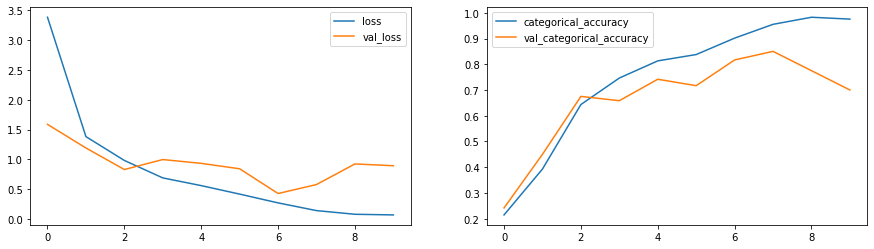

In [17]:
import matplotlib.pyplot as plt
plot(history)

## More copnv3d layers


In [47]:
input_shape=(15,120,120,3)
model1=Sequential()
model1.add(Conv3D(32,(3,3,3),activation='relu',padding='same',input_shape=input_shape))
model1.add(MaxPooling3D((2,2,2),padding='same'))
model1.add(Conv3D(64,(3,3,3),padding='same',activation='relu'))
model1.add(MaxPooling3D((2,2,2),padding='same'))
model1.add(Conv3D(128,(3,3,3),padding='same',activation='relu'))
model1.add(MaxPooling3D((2,2,2),padding='same'))
model1.add(Conv3D(256,(3,3,3),padding='same',activation='relu'))
model1.add(MaxPooling3D((2,2,2),padding='same'))
model1.add(Conv3D(512,(3,3,3),padding='same',activation='relu'))
model1.add(MaxPooling3D((2,2,2),padding='same'))
model1.add(Flatten())
model1.add(Dense(544))
#model1.add(Dropout(0.25))
model1.add(Dense(5,activation='softmax'))
model1.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_112 (Conv3D)          (None, 32, 120, 120, 3)   12992     
_________________________________________________________________
max_pooling3d_100 (MaxPoolin (None, 32, 60, 60, 2)     0         
_________________________________________________________________
conv3d_113 (Conv3D)          (None, 64, 60, 60, 2)     55360     
_________________________________________________________________
max_pooling3d_101 (MaxPoolin (None, 64, 30, 30, 1)     0         
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 128, 30, 30, 1)    221312    
_________________________________________________________________
max_pooling3d_102 (MaxPoolin (None, 128, 15, 15, 1)    0         
_________________________________________________________________
conv3d_115 (Conv3D)          (None, 256, 15, 15, 1)  

In [48]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_112 (Conv3D)          (None, 32, 120, 120, 3)   12992     
_________________________________________________________________
max_pooling3d_100 (MaxPoolin (None, 32, 60, 60, 2)     0         
_________________________________________________________________
conv3d_113 (Conv3D)          (None, 64, 60, 60, 2)     55360     
_________________________________________________________________
max_pooling3d_101 (MaxPoolin (None, 64, 30, 30, 1)     0         
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 128, 30, 30, 1)    221312    
_________________________________________________________________
max_pooling3d_102 (MaxPoolin (None, 128, 15, 15, 1)    0         
_________________________________________________________________
conv3d_115 (Conv3D)          (None, 256, 15, 15, 1)  

In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_name = 'simple_conv3d' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history=model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.7226 - categorical_accuracy: 0.2058Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to simple_conv3d_2021-05-3105_26_44.203869/model-00001-1.72256-0.20580-1.59724-0.24167.h5
23/23 [==============================] - 88s 4s/step - loss: 1.7226 - categorical_accuracy: 0.2058 - val_loss: 1.5972 - val_categorical_accuracy: 0.2417
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.6102 - categorical_accuracy: 0.2203
Epoch 00002: saving model to simple_conv3d_2021-05-3105_26_44.203869/model-00002-1.61023-0.22029-1.60102-0.19167.h5
23/23 [==============================] - 88s 4s/step - loss: 1.6102 - categorical_accuracy: 0.2203 - val_loss: 1.6010 - val_categorical_accuracy: 0.1917
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.5959 - categorical_accuracy: 0.2333
Epoch 00003:

### let's try adding batchnoramlisation and dropout

In [11]:
input_shape=(15,120,120,3)
model2=Sequential()
model2.add(Conv3D(32,(3,3,3),activation='relu',padding='same',input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(MaxPooling3D((2,2,2)))
model2.add(Conv3D(64,(3,3,3),padding='same',activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(MaxPooling3D((2,2,2)))
model2.add(Conv3D(128,(3,3,3),padding='same',activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(MaxPooling3D((2,2,2)))
model2.add(Flatten())
model2.add(Dense(544))
model2.add(Dropout(0.25))
model2.add(Dense(5,activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 60, 60, 64)     55360     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 60, 60, 64)     256       
_________________________________________________________________
dropout (Dropout)            (None, 7, 60, 60, 64)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 30, 30, 64)    

In [12]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 60, 60, 64)     55360     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 60, 60, 64)     256       
_________________________________________________________________
dropout (Dropout)            (None, 7, 60, 60, 64)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 30, 30, 64)    

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'simple_conv3d(bacthnormalization)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
history=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 71.2535 - categorical_accuracy: 0.3449Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to simple_conv3d(bacthnormalization)_2021-05-2508_45_03.212951/model-00001-71.25352-0.34493-29.77142-0.20000.h5
23/23 [==============================] - 84s 4s/step - loss: 71.2535 - categorical_accuracy: 0.3449 - val_loss: 29.7714 - val_categorical_accuracy: 0.2000
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 5.7275 - categorical_accuracy: 0.5478
Epoch 00002: saving model to simple_conv3d(bacthnormalization)_2021-05-2508_45_03.212951/model-00002-5.72748-0.54783-64.66763-0.20000.h5
23/23 [==============================] - 82s 4s/step - loss: 5.7275 - categorical_accuracy: 0.5478 - val_loss: 64.6676 - val_categorical_accuracy: 0.2000
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6

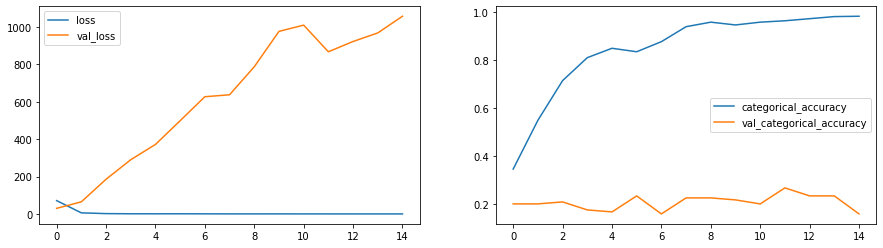

In [19]:
import matplotlib.pyplot as plt
plot(history)

## we can see that our model clearly overfitting after batchnormalization

### let's reduce hidden units from each layer

In [22]:
input_shape=(15,120,120,3)
model3=Sequential()
model3.add(Conv3D(16,(3,3,3),activation='relu',padding='same',input_shape=input_shape))
model3.add(BatchNormalization())
model3.add(MaxPooling3D((2,2,2)))
model3.add(Conv3D(32,(3,3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(MaxPooling3D((2,2,2)))
model3.add(Conv3D(62,(3,3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(MaxPooling3D((2,2,2)))
model3.add(Flatten())
model3.add(Dense(544))
model3.add(Dropout(0.25))
model3.add(Dense(5,activation='softmax'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 60, 60, 32)     128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 30, 30, 32)    

In [23]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 60, 60, 32)     128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 30, 30, 32)    

In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'simple_conv3d(bacthnormalization and less parmas)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
history=model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 50.6891 - categorical_accuracy: 0.3652Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to simple_conv3d(bacthnormalization and less parmas)_2021-05-2508_45_03.212951/model-00001-50.68905-0.36522-13.58434-0.22500.h5
23/23 [==============================] - 85s 4s/step - loss: 50.6891 - categorical_accuracy: 0.3652 - val_loss: 13.5843 - val_categorical_accuracy: 0.2250
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 2.4935 - categorical_accuracy: 0.6580
Epoch 00002: saving model to simple_conv3d(bacthnormalization and less parmas)_2021-05-2508_45_03.212951/model-00002-2.49350-0.65797-8.08317-0.26667.h5
23/23 [==============================] - 86s 4s/step - loss: 2.4935 - categorical_accuracy: 0.6580 - val_loss: 8.0832 - val_categorical_accuracy: 0.2667
Epoch 3/15
23/23 [=======================

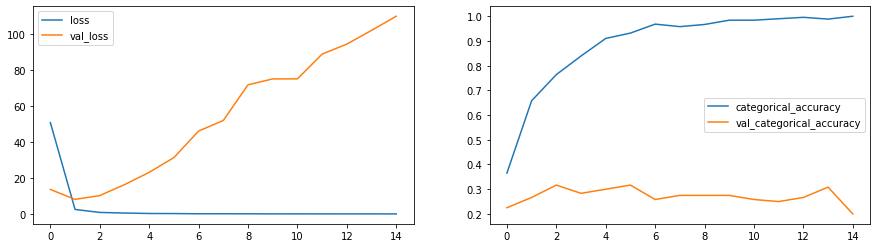

In [28]:
plot(history)

### we can clearly see that reducing parameters does not improvving model performance amd it is overfittting

#### let's try GRU with Conv2D

In [39]:
input_shape=(15,120,120,3)
model4=Sequential()
model4.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=input_shape))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Flatten()))
model4.add(GRU(128))
model4.add(Dense(512,activation='relu'))
model4.add(Dense(5,activation='softmax'))
model4.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 15, 15, 128)  

In [40]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 15, 15, 128)  

In [41]:
model_name = 'conv2d_Gru' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
ES=EarlyStopping(monitor='categorical_accuracy',patience=4)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR,ES]

In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
history=model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6170 - categorical_accuracy: 0.2652Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to conv2d_Gru_2021-05-2510_08_49.299132/model-00001-1.61697-0.26522-1.56914-0.24167.h5
23/23 [==============================] - 76s 3s/step - loss: 1.6170 - categorical_accuracy: 0.2652 - val_loss: 1.5691 - val_categorical_accuracy: 0.2417
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.4682 - categorical_accuracy: 0.3333
Epoch 00002: saving model to conv2d_Gru_2021-05-2510_08_49.299132/model-00002-1.46824-0.33333-1.24612-0.52500.h5
23/23 [==============================] - 77s 3s/step - loss: 1.4682 - categorical_accuracy: 0.3333 - val_loss: 1.2461 - val_categorical_accuracy: 0.5250
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.2105 - categorical_accuracy: 0.5319
Epoch 00003: savin

## clearly conv2d and gru does not seem to be performing well
### lets add regularization and recurrent dropout with more layers

In [29]:
input_shape=(15,120,120,3)
model4=Sequential()
model4.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=input_shape))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(512,(3,3),padding='same',activation='relu',)))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Flatten()))
model4.add(GRU(128,dropout=0.2,recurrent_dropout=0.2))
model4.add(Dense(544,activation='relu',))
model4.add(Dense(5,activation='softmax'))
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 15, 15, 128)  

In [34]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 15, 15, 128)  

In [35]:
model_name = 'conv2d_Gru(regu_dropout_new)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
ES=EarlyStopping(monitor='categorical_accuracy',patience=7)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR,ES]

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
history=model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6165 - categorical_accuracy: 0.2246Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.60851, saving model to conv2d_Gru(regu_dropout_new)_2021-05-2805_13_36.263269/model-00001-1.61646-0.22464-1.60851-0.21667.h5
23/23 [==============================] - 82s 4s/step - loss: 1.6165 - categorical_accuracy: 0.2246 - val_loss: 1.6085 - val_categorical_accuracy: 0.2167
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5970 - categorical_accuracy: 0.2232
Epoch 00002: val_loss improved from 1.60851 to 1.58836, saving model to conv2d_Gru(regu_dropout_new)_2021-05-2805_13_36.263269/model-00002-1.59700-0.22319-1.58836-0.36667.h5
23/23 [==============================] - 80s 3s/step - loss: 1.5970 - categorical_accuracy: 0.2232 - val_loss: 1.5884 - val_categorical_accuracy: 0.3667
Epoch 

In [38]:
history=model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.6114 - categorical_accuracy: 0.2072Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.60218, saving model to conv2d_Gru(regu_dropout_new)_2021-05-2808_27_32.945661/model-00001-1.61137-0.20725-1.60218-0.35833.h5
23/23 [==============================] - 77s 3s/step - loss: 1.6114 - categorical_accuracy: 0.2072 - val_loss: 1.6022 - val_categorical_accuracy: 0.3583
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accuracy: 0.2101
Epoch 00002: val_loss did not improve from 1.60218
23/23 [==============================] - 79s 3s/step - loss: 1.6098 - categorical_accuracy: 0.2101 - val_loss: 1.6093 - val_categorical_accuracy: 0.1917
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.6097 - categorical_accuracy: 0.2116
Epoch 00003: val_loss d

In [11]:
input_shape=(15,120,120,3)
model4=Sequential()
model4.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.001)),input_shape=input_shape))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.001))))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.001))))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.001))))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Conv2D(512,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.001))))
model4.add(TimeDistributed(MaxPooling2D(2,2)))
model4.add(TimeDistributed(Flatten()))
model4.add(GRU(64,dropout=0.2,recurrent_dropout=0.2))
model4.add(Dense(524,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model4.add(Dense(5,activation='softmax'))
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 30, 30, 128)   73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 15, 15, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 15, 15, 256)   2

In [15]:
model_name = 'conv2d_Gru(regu_More_layers)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
ES=EarlyStopping(monitor='val_categorical_accuracy',patience=7)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR,ES]

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
optimiser = keras.optimizers.Adam(lr=0.002) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 30, 30, 128)   73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 15, 15, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 15, 15, 256)   2

In [ ]:
history=model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.9765 - categorical_accuracy: 0.2043Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.76863, saving model to conv2d_Gru(regu_More_layers)_2021-05-2808_00_26.676747/model-00001-1.97654-0.20435-1.76863-0.24167.h5
23/23 [==============================] - 77s 3s/step - loss: 1.9765 - categorical_accuracy: 0.2043 - val_loss: 1.7686 - val_categorical_accuracy: 0.2417
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.7268 - categorical_accuracy: 0.2058
Epoch 00002: val_loss improved from 1.76863 to 1.68476, saving model to conv2d_Gru(regu_More_layers)_2021-05-2808_00_26.676747/model-00002-1.72680-0.20580-1.68476-0.19167.h5
23/23 [==============================] - 79s 3s/step - loss: 1.7268 - categorical_accuracy: 0.2058 - val_loss: 1.6848 - val_categorical_accuracy: 0.1917
Epoch 

#### conv2d +LSTM

In [25]:
input_shape=(15,120,120,3)
model5=Sequential()
model5.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=input_shape))
model5.add(TimeDistributed(MaxPooling2D(2,2)))
model5.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D(2,2)))
model5.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D(2,2)))
model5.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D(2,2)))
model5.add(TimeDistributed(Conv2D(512,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D(2,2)))
model5.add(TimeDistributed(Flatten()))
model5.add(LSTM(64))
model5.add(Dense(524,activation='relu'))
model5.add(Dense(5,activation='softmax'))
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_52 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_57 (TimeDis (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 15, 15, 128)  

In [26]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_52 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_57 (TimeDis (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 15, 15, 128)  

In [27]:
model_name = 'conv2d_Gru(conv2d+lstm)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#ES=EarlyStopping(monitor='categorical_accuracy',patience=4)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
history=model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.6132 - categorical_accuracy: 0.1913Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.60794, saving model to conv2d_Gru(conv2d+lstm)_2021-05-2805_13_36.263269/model-00001-1.61322-0.19130-1.60794-0.18333.h5
23/23 [==============================] - 81s 4s/step - loss: 1.6132 - categorical_accuracy: 0.1913 - val_loss: 1.6079 - val_categorical_accuracy: 0.1833
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6062 - categorical_accuracy: 0.2217
Epoch 00002: val_loss improved from 1.60794 to 1.57841, saving model to conv2d_Gru(conv2d+lstm)_2021-05-2805_13_36.263269/model-00002-1.60619-0.22174-1.57841-0.25000.h5
23/23 [==============================] - 80s 3s/step - loss: 1.6062 - categorical_accuracy: 0.2217 - val_loss: 1.5784 - val_categorical_accuracy: 0.2500
Epoch 3/25
23/23

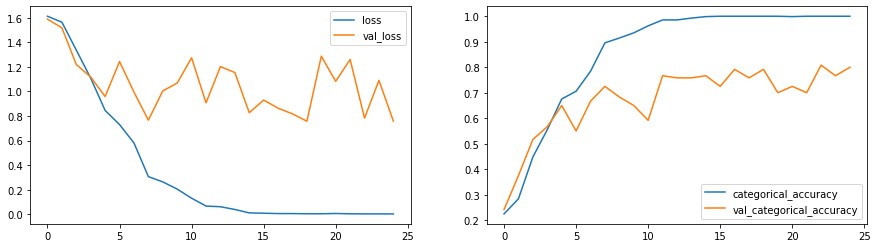

In [25]:
plot(history)

## lets add dropouts and regularisation

In [48]:
input_shape=(15,120,120,3)
model5=Sequential()
model5.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l1(0.001)),input_shape=input_shape))
model5.add(TimeDistributed(MaxPooling2D(2,2)))
model5.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l1(0.001))))
model5.add(TimeDistributed(MaxPooling2D((2,2))))

model5.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l1(0.001))))
model5.add(TimeDistributed(MaxPooling2D(2,2)))

#model5.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.001))))
#model5.add(TimeDistributed(MaxPooling2D(2,2)))

model5.add(TimeDistributed(Flatten()))
model5.add(LSTM(64,dropout=0.2,recurrent_dropout=0.2))
model5.add(Dense(524,activation='relu',kernel_regularizer=regularizers.l1(0.001)))
model5.add(Dense(5,activation='softmax'))
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_96 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_97 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_99 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_100 (TimeDi (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_101 (TimeDi (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, 15, 14400)        

In [49]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_96 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_97 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_99 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_100 (TimeDi (None, 15, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_101 (TimeDi (None, 15, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, 15, 14400)        

In [50]:
model_name = 'conv2d_Gru(conv2d+lstm(dropout_regu2))' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#ES=EarlyStopping(monitor='categorical_accuracy',patience=4)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [51]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [53]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
history=model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 3.9153 - categorical_accuracy: 0.2870Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 3.45444, saving model to conv2d_Gru(conv2d+lstm(dropout_regu2))_2021-05-2607_38_02.538695/model-00001-3.91528-0.28696-3.45444-0.35000.h5
23/23 [==============================] - 83s 4s/step - loss: 3.9153 - categorical_accuracy: 0.2870 - val_loss: 3.4544 - val_categorical_accuracy: 0.3500
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 3.0094 - categorical_accuracy: 0.4435
Epoch 00002: val_loss improved from 3.45444 to 2.62563, saving model to conv2d_Gru(conv2d+lstm(dropout_regu2))_2021-05-2607_38_02.538695/model-00002-3.00943-0.44348-2.62563-0.47500.h5
23/23 [==============================] - 78s 3s/step - loss: 3.0094 - categorical_accuracy: 0.4435 - val_loss: 2.6256 - val_categorical_acc

KeyboardInterrupt: 

In [ ]:
fro